In [225]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [226]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [227]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [228]:
!unzip \*.zip && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [229]:
def wrangle(filepath):
  df= pd.read_csv(filepath,index_col = "PassengerId")

  #Rename Columns
  df = df.rename(columns = {'SibSp':"Sibling/Parents_Aboard", "Parch":"#_parents/children_aboard"})

  #Drop High Cardinality
  threshold =200
  columns_to_drop=[]
  for cols in df:
    if df[cols].dtype=='object':
      if df[cols].nunique()>threshold:
        columns_to_drop.append(cols)

  df.drop(columns=columns_to_drop,inplace=True)

  #Drop columns with large Null numbers
  df.drop(columns="Cabin",inplace=True)

  #Drop 2 nulls from embarked
  mask = df['Embarked'].isnull()==1
  df =df[~mask]

  return df

In [230]:
df = wrangle('train.csv')
df_X_test = wrangle('test.csv')

In [231]:
df

,Survived,Pclass,Sex,Age,Sibling/Parents_Aboard,#_parents/children_aboard,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,NaN,1,2,23.4500,S


In [232]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Sibling/Parents_Aboard',
       '#_parents/children_aboard', 'Fare', 'Embarked'],
      dtype='object')

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Survived                   889 non-null    int64  
 1   Pclass                     889 non-null    int64  
 2   Sex                        889 non-null    object 
 3   Age                        712 non-null    float64
 4   Sibling/Parents_Aboard     889 non-null    int64  
 5   #_parents/children_aboard  889 non-null    int64  
 6   Fare                       889 non-null    float64
 7   Embarked                   889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [234]:
df.isnull().sum()

Survived                       0
Pclass                         0
Sex                            0
Age                          177
Sibling/Parents_Aboard         0
#_parents/children_aboard      0
Fare                           0
Embarked                       0
dtype: int64

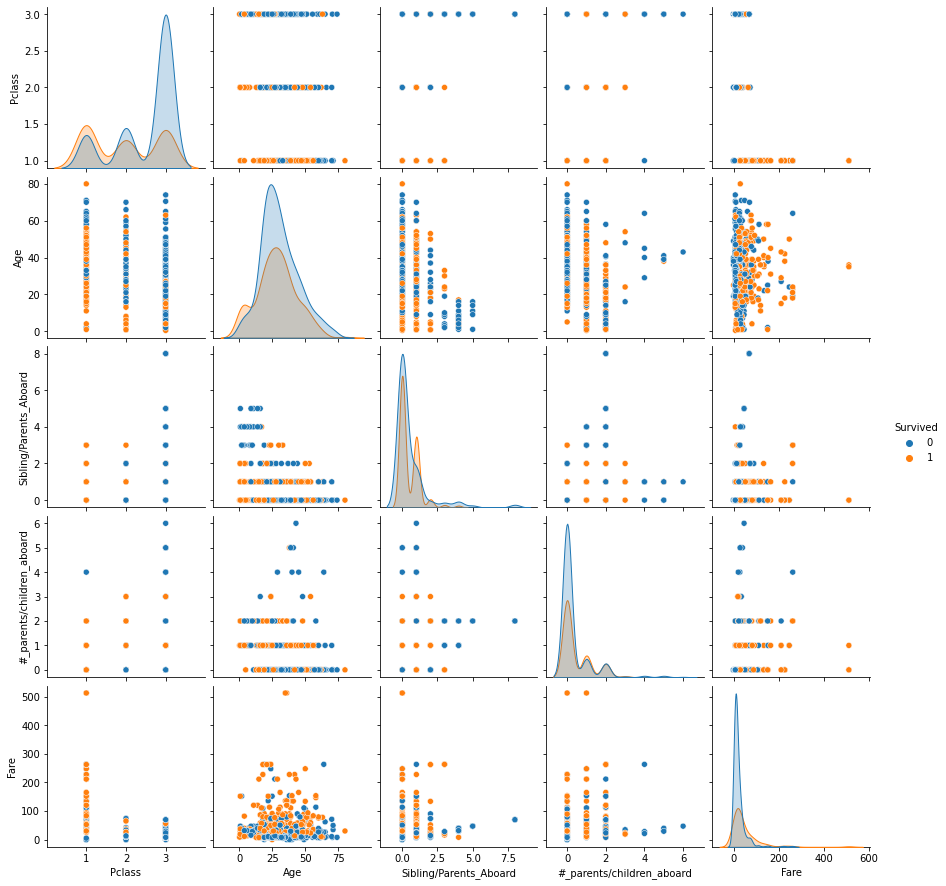

In [235]:
sns.pairplot(df, hue="Survived")

# Define Target

In [236]:
target='Survived'
X=df.drop(columns=target)
y=df[target]

# Baseline 

In [237]:
y_pred = [y.mean()]*len(y)
baseline_mae = mean_absolute_error(y,y_pred)
print("The basline mae is:",baseline_mae)

The basline mae is: 0.47236502636270583


# Split Data

In [238]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# Best Model

In [239]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(max_depth = 5, n_estimators=100, n_jobs=-1,random_state=42)
)

model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_jobs=-1,
                                        random_state=42))])

In [240]:
print("Model training score",model.score(X_train,y_train))
print("The model training mean absolute error is:",mean_absolute_error(y_train,model.predict(X_train)))

print("\n")
print("Model val score",model.score(X_val,y_val))
print("The model val mean absolute error is:",mean_absolute_error(y_val,model.predict(X_val)))


Model training score 0.8382559774964838
The model training mean absolute error is: 0.1617440225035162


Model val score 0.8146067415730337
The model val mean absolute error is: 0.1853932584269663


# Prediction

In [241]:
name ='Survived'
predictions = pd.DataFrame(model.predict_proba(df_X_test))
predictions.rename(columns={0:'Did_Not_Survive',1:name})

predictions2 = pd.DataFrame(model.predict(df_X_test))
predictions2.rename(columns={0:name})



,Survived
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


# Feature Importances

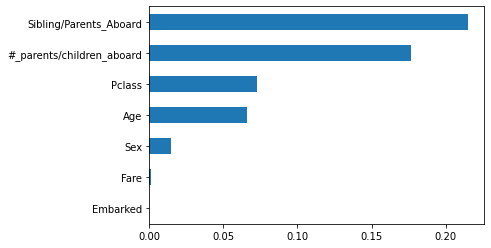

In [245]:
importances = model.named_steps['randomforestclassifier'].feature_importances_[:7]
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')